## Data Balanced

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()

# Función para limpiar texto
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in set(stopwords.words('english')) and len(word) > 2]
    return ' '.join(text)

# Cargar datos
df = pd.read_csv("../data/merged_reviews.csv")

# Filtrar puntaje 3 y convertir a clasificación binaria
df_binary = df[df["review/score"] != 3].copy()
df_binary["label"] = df_binary["review/score"].apply(lambda x: 1 if x > 3 else 0)

# Verificar desbalance
print("Distribución original:")
print(df_binary["label"].value_counts())

# Submuestreo para balancear
positivos = df_binary[df_binary["label"] == 1].sample(n=df_binary["label"].value_counts()[0], random_state=42)
negativos = df_binary[df_binary["label"] == 0]
balanced_df = pd.concat([positivos, negativos]).sample(frac=1, random_state=42).reset_index(drop=True)

# Limpieza de texto
balanced_df["clean_summary"] = balanced_df["review/summary"].apply(clean_text)

# Verificar resultado
print("\nDistribución balanceada:")
print(balanced_df["label"].value_counts())
print("\nEjemplo de resumen limpio:")
print(balanced_df[["review/summary", "clean_summary"]].head())

# Guardar dataset balanceado
balanced_df.to_csv("../data/balanced_reviews.csv", index=False)
print("\n✅ Dataset balanceado guardado como 'balanced_reviews.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Distribución original:
label
1    2392645
0     352683
Name: count, dtype: int64

Distribución balanceada:
label
1    352683
0    352683
Name: count, dtype: int64

Ejemplo de resumen limpio:
                                      review/summary  \
0                           Book for nonbelievers...   
1  Not so great in the first place, it is now wil...   
2                                    Did you know...   
3                                             Great!   
4                       I don't believe she wrote it   

                       clean_summary  
0                   book nonbeliever  
1  great first place wildly outdated  
2                               know  
3                              great  
4                      believe wrote  

✅ Dataset balanceado guardado como 'balanced_reviews.csv'


## Train

In [8]:
df = pd.read_csv("../data/balanced_reviews.csv")
print(df.columns)
# Corpus y etiquetas
corpus = df["clean_summary"].tolist()
y = df["label"].values

print(df.isna().sum())

Index(['review/summary', 'review/score', 'label', 'clean_summary'], dtype='object')
review/summary       0
review/score         0
label                0
clean_summary     5057
dtype: int64


## Modelos compatibles con sparse

In [6]:
import pandas as pd

# Cargar dataset balanceado
df = pd.read_csv("../data/balanced_reviews.csv")
print(df.head(10))


                                      review/summary  review/score  label  \
0                           Book for nonbelievers...           5.0      1   
1  Not so great in the first place, it is now wil...           2.0      0   
2                                    Did you know...           5.0      1   
3                                             Great!           5.0      1   
4                       I don't believe she wrote it           1.0      0   
5                          What Happened Angie Sage?           2.0      0   
6  Interesting idea and well written, but conscie...           1.0      0   
7                                 purely for fiction           2.0      0   
8                          Entertainment at its best           5.0      1   
9               Classic brilliance, plain and simple           5.0      1   

                                       clean_summary  
0                                   book nonbeliever  
1                  great first place wildl

In [24]:
import pandas as pd
import os
import sys
import joblib

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from machine_learning.scripts.data_prep import prepare_corpus
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


#BASE_DIR = os.path.abspath(os.getcwd(), '..')
#DATA_PATH = os.path.join(BASE_DIR, 'data', 'balanced_reviews.csv')

# Load data
#dataset = pd.read_csv(DATA_PATH)
dataset = pd.read_csv("../data/balanced_reviews.csv")
dataset = dataset.dropna(subset=["clean_summary"])
dataset["clean_summary"] = dataset["clean_summary"].astype(str)

# Reset indexes to avoid KeyError
dataset = dataset.reset_index(drop=True)

corpus = prepare_corpus(dataset, "clean_summary", limit=1000)
labels = dataset["label"].values[:len(corpus)]  # Asegura alineación

# Vectorize (sparse input)
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(corpus)

y = labels

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define models
# Only models compatible with sparse input:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "SVM": SVC(kernel='linear', class_weight='balanced', probability=True),
}

# Train & evaluate
results = []
trained_models = {}

for name, model in models.items():
    print(f"Trainning {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall
    })
    trained_models[name] = model


# Results DataFrame
df_results = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\n=== Model Results ===")
print(df_results)


# Save best model and vectorizer
best_model_name = df_results.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")


Trainning Logistic Regression...
Trainning SVM...

=== Model Results ===
                 Model  Accuracy        F1  Precision  Recall
1                  SVM     0.715  0.715122   0.715280   0.715
0  Logistic Regression     0.710  0.708466   0.709234   0.710
Best Model: SVM


In [ ]:
print(dataset['label'].value_counts())
print(dataset['label'].value_counts(normalize=True))  # proporciones

label
1    351498
0    348811
Name: count, dtype: int64
label
1    0.501918
0    0.498082
Name: proportion, dtype: float64


In [ ]:
print("Cantidad total de muestras:", len(dataset))

Cantidad total de muestras: 700309


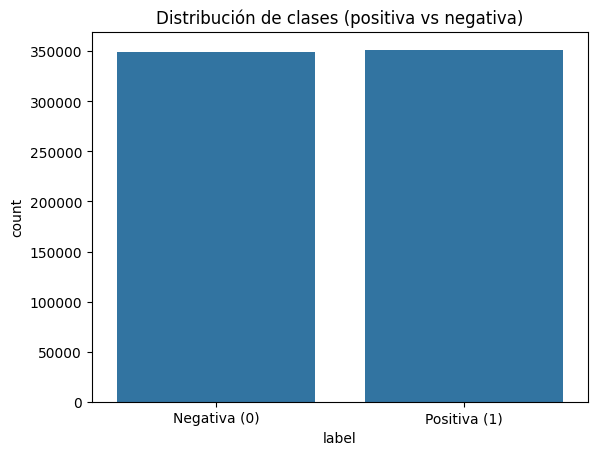

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=dataset)
plt.title("Distribución de clases (positiva vs negativa)")
plt.xticks([0,1], ["Negativa (0)", "Positiva (1)"])
plt.show()

In [28]:
print("Nulos por columna:")
print(dataset.isnull().sum())

print("Duplicados:", dataset.duplicated().sum())


Nulos por columna:
review/summary    0
review/score      0
label             0
clean_summary     0
dtype: int64
Duplicados: 227027


In [35]:
print("Duplicados:", dataset[dataset.duplicated(subset=["clean_summary"], keep=False)])

Duplicados:                                 review/summary  review/score  label  \
2                              Did you know...           5.0      1   
3                                       Great!           5.0      1   
4                 I don't believe she wrote it           1.0      0   
7                           purely for fiction           2.0      0   
8                    Entertainment at its best           5.0      1   
...                                        ...           ...    ...   
700303  A sublimely boring and depressing book           1.0      0   
700304            Says what needs to be said!!           4.0      1   
700305                  road through kurdistan           2.0      0   
700307  Depressing German bourgeois narcissism           2.0      0   
700308       Walt Whitman is a Great Read!!!!!           5.0      1   

                                 clean_summary  
2                                         know  
3                                    

In [30]:
min_count = min(dataset['label'].value_counts().values)
balanced = pd.concat([
    dataset[dataset['label'] == 0].sample(min_count, random_state=42),
    dataset[dataset['label'] == 1].sample(min_count, random_state=42)
])
